# Modern Data Analytics Tools on and Air-Gapped Network

## Overview
- How can I use modern data analytics tooling, such as Numpy, Matplotlib, and even PyTorch on an air-gapped network?

### Example Analysis:

#### Imports/Setup

In [24]:
from math import sqrt
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.linear_model import LinearRegression
from dask.distributed import Client, progress
import dask.bag
import dask.dataframe
import metaflow
import opal.flow
import yaml
from opal.weave.create_index import create_index_from_s3
s3 = opal.flow.minio_s3fs()

#### Gather References to Uploaded Data
- Use OPAL's Weave package to access metadata from over 500 Chapter 10s stored on AWS S3 storage

In [25]:
index = create_index_from_s3('basket-data-with-arinc', 'schema.json')

In [26]:
# Use index to access and sort all of the information we need
def get_all_uuids_of_specific_type(index, basket_type):
    return index[index["basket_type"] == basket_type]["uuid"].tolist()
def get_first_gen_children(parsed_ch10_uuid, index):
    return index[
        [(parsed_ch10_uuid in puuid) for puuid in index["parent_uuids"]]
    ]
def get_address_of_specific_type(parsed_ch10_uuid, index, basket_type):
    first_gen_children = get_first_gen_children(parsed_ch10_uuid, index)
    index_subset = first_gen_children[
        first_gen_children["basket_type"] == basket_type
    ]
    if len(index_subset) != 1:
        raise RuntimeError(
            f"There is not exactly one {basket_type} "
            f"child basket for UUID: {parsed_ch10_uuid}"
        )
    return index_subset["address"].iloc[0]
parsed_ch10_uuids = get_all_uuids_of_specific_type(
    index=index, basket_type="ch10_parsed"
)

arinc_and_1553_addresses = [
    {
        "MILSTD1553": get_address_of_specific_type(
            uuid, index, "ch10_translated_MILSTD1553"
        ),
        "ARINC429": get_address_of_specific_type(
            uuid, index, "ch10_translated_ARINC429"
        )
    }
    for uuid in parsed_ch10_uuids
]

#### Find and plot cruising altitude across one flight
- Utilize Pandas and Numpy libraries to quickly and efficiently subset and transform data.
- Utilize Matplotlib to easily create an informative plot

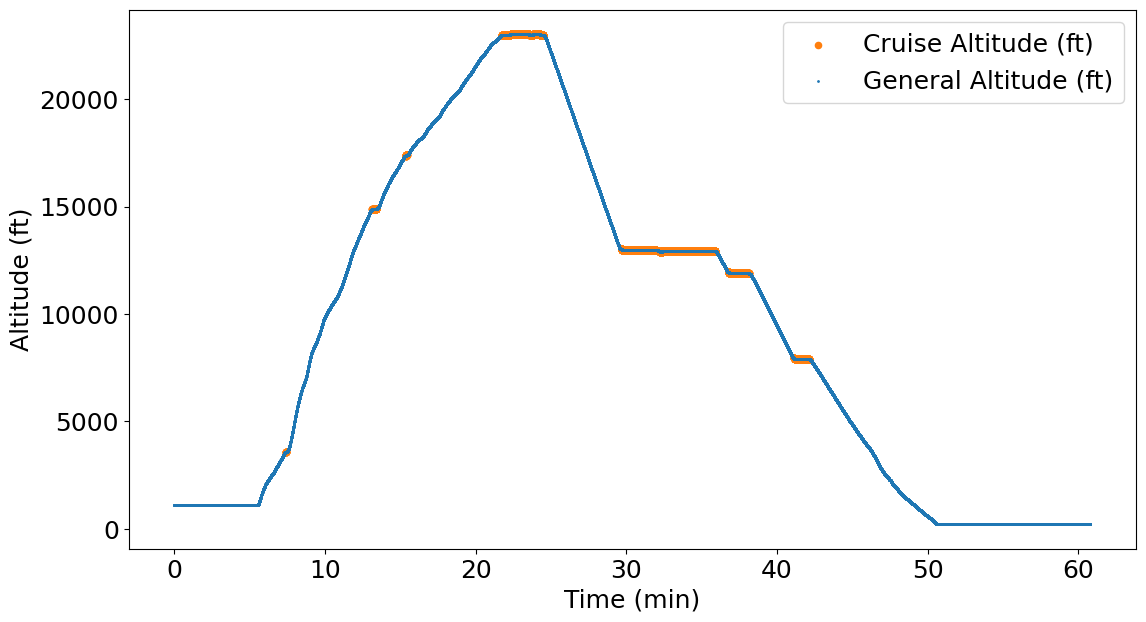

In [27]:
plt.rcParams.update({"font.size":18})
altitude = "NAV-25"
altitude_valid = "NAV-0111"
rpm = "N1_RPM_ACTUAL"
rpm_dataset = "Engine_Fan_RPM_N1_ACTUAL_40"

def plot_cruise_altitude(t_1553):
    # Get the 1553 data
    original_df = pd.read_parquet(t_1553, filesystem=s3)
    original_df["time"] = (
        original_df["time"] - original_df["time"].iloc[0]
    ) / 10**9 / 60
    df_1553 = original_df
    
    # Filter 1553 by the 'altitude valid'
    df_1553 = df_1553[df_1553[altitude_valid]]
    df_1553 = df_1553.dropna()
    
    # Calculate change in altitude over time (time is in nanoseconds)
    df_1553.loc[:,"diff_altitude"] = (
        df_1553[altitude].diff() / (df_1553["time"].diff() / 10**9)
    )
    # Smooth out the altitude derivative
    df_1553.loc[:,"diff_altitude"] = (
        df_1553["diff_altitude"].rolling(int(1 / 0.04)).mean()
    )
    
    # Select only where altitude rate of change is small enough (< 0.25 ft/sec.)
    # and the aircraft is sufficiently above what we think is ground level
    start_altitude = df_1553[altitude].iloc[:10].mean()
    end_altitude = df_1553[altitude].iloc[-10:].mean()
    min_altitude = max(start_altitude, end_altitude)
    df_1553 = df_1553[abs(df_1553["diff_altitude"]) < 0.25]
    df_1553 = df_1553[df_1553[altitude] > min_altitude * 2]
    df_1553 = df_1553.dropna()
    
    # Create the plots
    ax = df_1553.plot(kind="scatter", x="time", y=altitude,
                      c="tab:orange", label="Cruise Altitude (ft)",
                      figsize=(13,7))
    original_df.plot(kind="scatter", x='time', y=altitude,
                     ax=ax, label="General Altitude (ft)", s=1)
    ax.set_ylabel("Altitude (ft)")
    ax.set_xlabel("Time (min)")

# basket = translated_index[translated_index.label == '652200101100441'].iloc[0]
basket = index[
    np.array(index["label"] == '652200101100441') &
    np.array(index["basket_type"] == "ch10_translated_MILSTD1553")
]
nav_path = os.path.join(basket['address'].iloc[0],
                        'parsed_data_translated', 'NAV.parquet', '00.parquet')
plot_cruise_altitude(nav_path)

#### Utilize available modern analytics tooling to process 500+ Chapter 10s in tandem
- Dask libraries enable multiprocessing
- OPAL can process all of these Chapter 10s in well under one minute.

In [28]:
def get_rpm_at_cruise_altitude(t_1553, t_429):
    # get the 1553 and ARINC429 data
    t_1553 = os.path.join(t_1553, 'parsed_data_translated',
                          'NAV.parquet', '00.parquet')
    t_429 = os.path.join(t_429,'parsed_data_translated',
                         f'{rpm_dataset}.parquet', '00.parquet')
    df_1553 = pd.read_parquet(t_1553, filesystem=s3)
    df_429 = pd.read_parquet(t_429, filesystem=s3)
    
    # filter 1553 by the 'altitude valid' bit
    df_1553 = df_1553[df_1553[altitude_valid]]
    
    # join 1553 and ARINC429 data by time
    joined = pd.concat([ df_1553, df_429 ]).sort_values("time")
    joined[rpm] = joined[rpm].fillna(method="ffill")
    joined = joined.dropna().copy()
    
    # calculate change in altitude over time (time is in nanoseconds)
    joined.loc[:,"diff_altitude"] = (
        joined[altitude].diff() / (joined["time"].diff() / 10**9)
    )
    # smooth out the altitude derivative
    joined.loc[:,"diff_altitude"] = (
        joined["diff_altitude"].rolling(int(1 / 0.04)).mean()
    )
    
    # select only where difference in altitude is small enough
    # and the aircraft is sufficiently above what we think is ground level
    start_altitude = joined[altitude].iloc[:10].mean()
    end_altitude = joined[altitude].iloc[-10:].mean()
    min_altitude = max(start_altitude, end_altitude)
    joined = joined[abs(joined["diff_altitude"]) < 0.25]
    joined = joined[joined[altitude] > min_altitude * 2]
    joined = joined.dropna()
    
    # group periods of time when the jet was cruising, take the average
    joined['group'] = (joined['time'].diff() > 60 * 10**9).cumsum()
    grouped = joined.groupby('group').mean(numeric_only=True)
    return grouped

with Client(n_workers=16, processes=True) as client:  
    dashboard_port = client.cluster.dashboard_link.split(':')[-1].split('/')[0]
    dashboard_link = (
        f"https://opal.opalacceptance.dso.mil"
        f"{os.environ['JUPYTERHUB_SERVICE_PREFIX']}"
        f"proxy/{dashboard_port}/status"
    )
    print(dashboard_link)
    # ds_bag = dask.bag.from_sequence(translated_index.iloc)
    ds_bag = dask.bag.from_sequence(arinc_and_1553_addresses)
    
    analysis_count = ds_bag.count().compute()
    ds_bag = ds_bag.map(
        lambda address_tuple: get_rpm_at_cruise_altitude(
            address_tuple['MILSTD1553'], address_tuple['ARINC429']
        )
    )
    future = client.compute(ds_bag)
    progress(future, notebook=False)
    df = pd.concat(future.result())

print(f' Datasets Analyzed = {analysis_count}')

https://opal.opalacceptance.dso.mil/user/n.christiansen/proxy/8787/status
 Datasets Analyzed = 559#################] | 100% Completed | 31.2s


### Plot Results

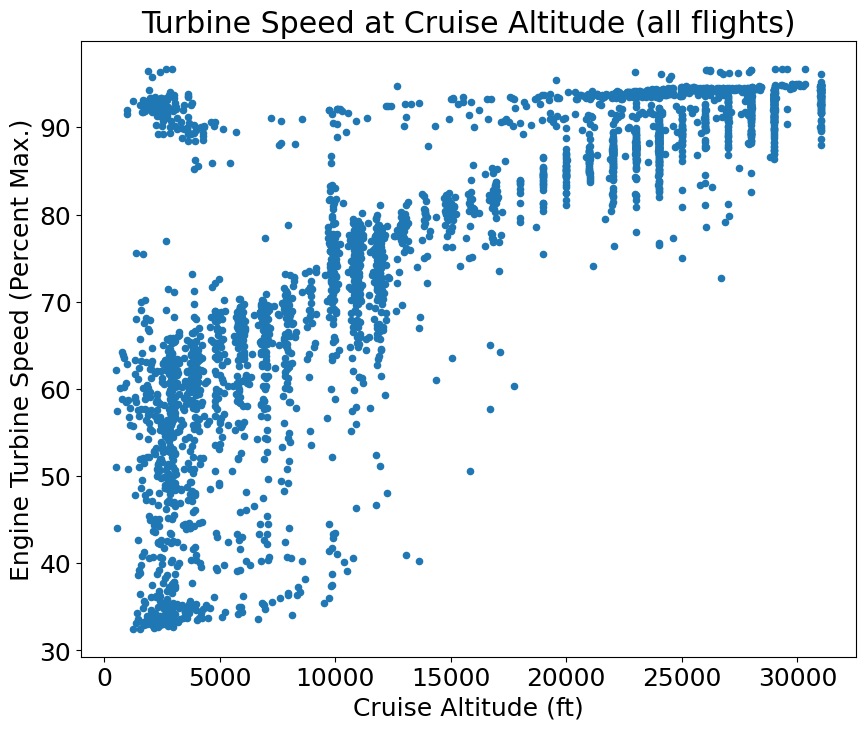

In [29]:
df.plot(
    kind="scatter", x=altitude, y=rpm, 
    xlabel="Cruise Altitude (ft)", ylabel="Engine Turbine Speed (Percent Max.)",
    title="Turbine Speed at Cruise Altitude (all flights)",
    figsize=(10, 8)
)
plt.show()

## Investigate potential correlations between turbine speed and cruise altitude

### Fit the Data to a Linear Regression Model

In [30]:
turbine_speed = np.array(df['NAV-25']).reshape(-1,1)
X = df.drop(columns = ['time', 'N1_RPM_ACTUAL', 'diff_altitude'])
y = df['N1_RPM_ACTUAL']
all_columns_reg = LinearRegression().fit(X, y)
turbine_speed_reg = LinearRegression().fit(turbine_speed, y)

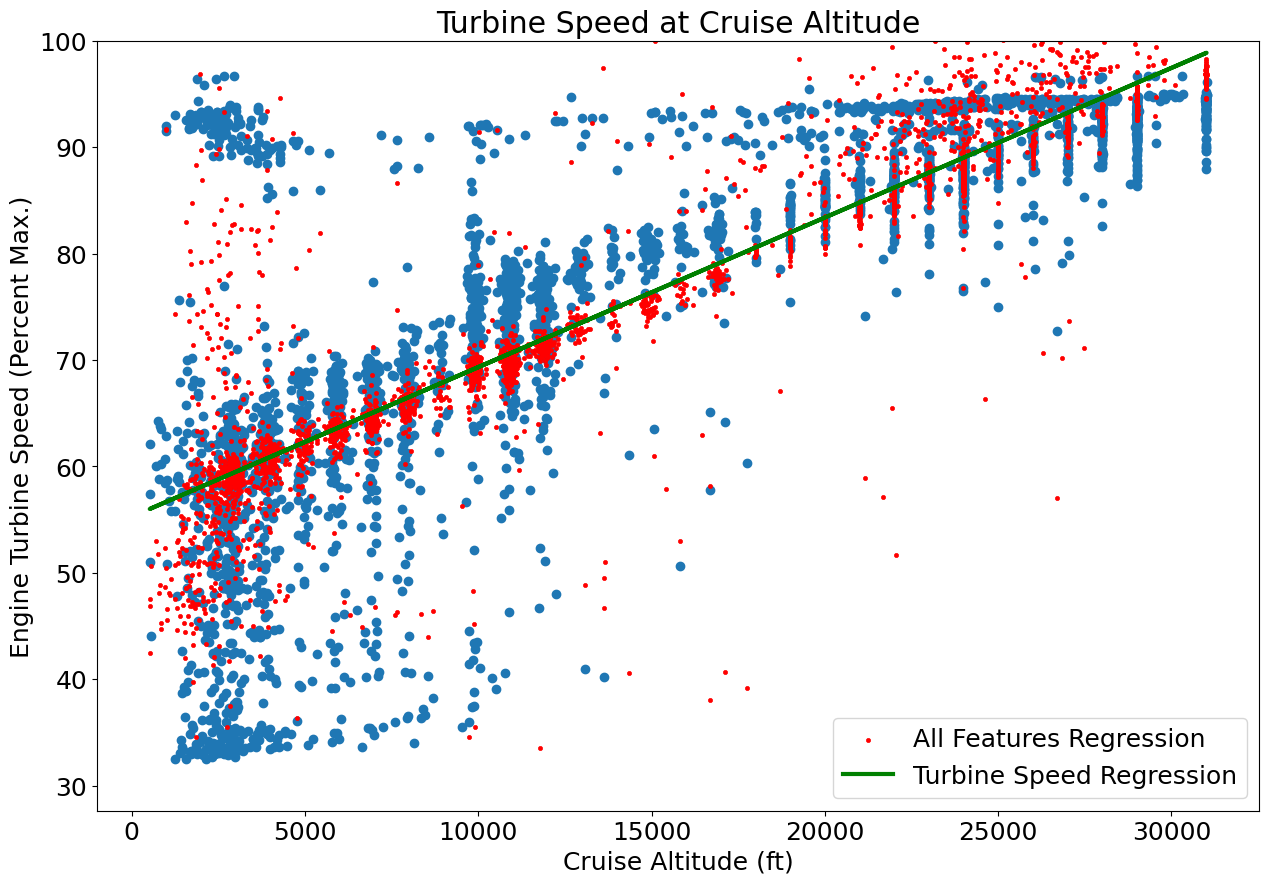

In [31]:
fig = plt.figure(figsize=(15, 10))
plt.title("Turbine Speed at Cruise Altitude")
plt.scatter(X['NAV-25'], y)
plt.scatter(X['NAV-25'].sort_values(), all_columns_reg.predict(X.sort_values('NAV-25')), marker = '.', c = 'r',
         label='All Features Regression', linewidth = .5)
plt.plot(turbine_speed, turbine_speed_reg.predict(turbine_speed),
         color='g', label='Turbine Speed Regression', linewidth = 3)

plt.xlabel("Cruise Altitude (ft)")
plt.ylabel ("Engine Turbine Speed (Percent Max.)")
plt.ylim(top=100)
plt.legend()
plt.show()

### R<sup>2</sup> Score for each Model

In [32]:
print('All Features Regression score: ', all_columns_reg.score(X, y))
print('Turbine Speed Regression score: ', turbine_speed_reg.score(turbine_speed, y))

All Features Regression score:  0.7638063453061499
Turbine Speed Regression score:  0.621562077266621


### Calculate Correlation Coefficients

In [33]:
address = index[index.basket_type == 'NASA_MILSTD1553_DTS'].address.iloc[0]
with s3.open(os.path.join(address, 'NASA_MILSTD1553_DTS.yaml')) as file:
    dts_1553 = yaml.safe_load(file)
translation = {}
for key in dts_1553['translatable_message_definitions']['NAV']['word_elem'].keys():
    translation[key] = dts_1553['translatable_message_definitions']['NAV']['word_elem'][key]['desc']

cors_with_target = X.rename(columns = translation).corrwith(y)
cors_with_target.sort_values(ascending=False)

Altitude            0.788392
Aircraft Pitch      0.300719
Longitude           0.076955
X Velocity          0.066702
Y Velocity          0.014017
Aircraft Azimuth    0.006172
True Heading        0.006172
Z Acceleration     -0.025799
Latitude           -0.051720
Aircraft Roll      -0.061310
Y Acceleration     -0.067917
X Acceleration     -0.101107
Z Velocity         -0.460473
Magnetic Heading         NaN
dtype: float64

# Conclusion

- Engine Turbine Speed is "Highly Correlated" with Cruise Altitude (0.79 pearson correlation) 
- A Linear Model isn't a great model to predict Engine Turbine RPM given Cruise Altitude (62% accuracy)
- 559 flights were analyzed within ~ 1 minute using 16 workers with Dask